Tensor data shape: (1, 640, 640, 3)

0: 640x640 1 person, 1 sports ball, 85.2ms
Speed: 0.0ms preprocess, 85.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


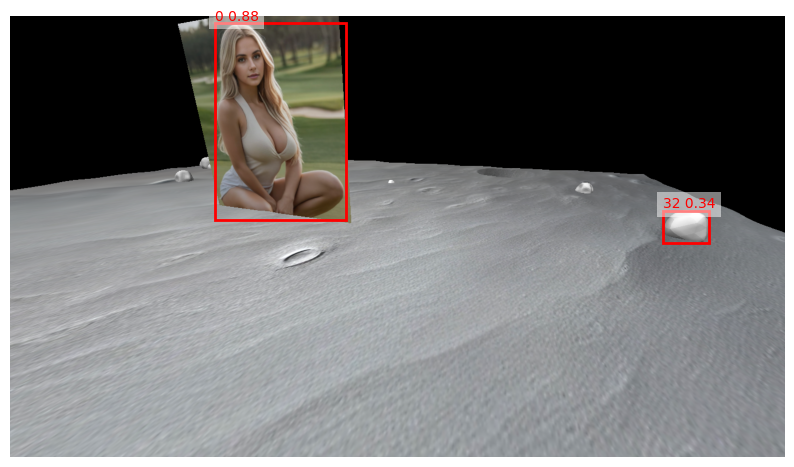

In [9]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
import torch

# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# Load the tensor data
with open('./test/tensor_data-4.json', 'r') as f:
    tensor_data = np.array(json.load(f), dtype=np.float32)

print("Tensor data shape:", tensor_data.shape)

# Remove the batch dimension
tensor_data = tensor_data[0]  # Shape becomes (640, 640, 3)

# Convert the tensor back to a Torch tensor and reshape it
tensor = torch.tensor(tensor_data).permute(2, 0, 1).unsqueeze(0)  # Convert HWC -> CHW -> BCHW

# Perform inference using the tensor
results = model.predict(source=tensor)

# Load the original image for visualization
original_image = Image.open('./test/webgl_image-4.png')
original_width, original_height = original_image.size
image_np = np.array(original_image)

# Get YOLO input size
yolo_input_size = tensor_data.shape[:2]  # (640, 640)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_np)

# Draw bounding boxes from the predictions
for bbox in results[0].boxes:
    x1, y1, x2, y2 = bbox.xyxy[0].tolist()  # Extract bounding box coordinates
    confidence = bbox.conf[0].item()  # Extract confidence score
    label = bbox.cls[0].item()  # Extract class label

    # Scale bounding box coordinates back to original image dimensions
    x1 = x1 * (original_width / yolo_input_size[1])
    y1 = y1 * (original_height / yolo_input_size[0])
    x2 = x2 * (original_width / yolo_input_size[1])
    y2 = y2 * (original_height / yolo_input_size[0])

    # Draw the rectangle
    plt.gca().add_patch(plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2
    ))

    # Add label and confidence
    plt.text(x1, y1 - 5, f'{int(label)} {confidence:.2f}', color='red',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.axis('off')
plt.show()